# US Accident

## Import

In [682]:
import seaborn as sns;
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split as TTS
from sklearn.model_selection import cross_val_score;
from sklearn.preprocessing import LabelEncoder;
from sklearn.ensemble import RandomForestClassifier

# pipeline elements
from sklearn.decomposition import PCA # PCA = Principal Component Analysis
from sklearn.neighbors import KNeighborsClassifier as KNN 

# pipeline materiaux
from sklearn.pipeline import Pipeline # PCA = Principal Component Analysis
from sklearn.model_selection import GridSearchCV

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from itertools import cycle


## Fonction

In [683]:
# Créer une mesure de performance

def accuracy(preds, target):
    M = target.shape[0] # Nombre d'exemple
    total_correctes = (preds == target).sum()
    accuracy = total_correctes / M
    return accuracy

In [684]:
# Afficher la matrice de confusion

def show_cm(cm, labels):
    df_cm = pd.DataFrame(cm, labels, labels)
    sns.heatmap(df_cm, annot=True)
    plt.show()

## Collecte de données

Nous allons étudier un dataset qui regroupent un enssemble d'accidents de voitures ayant eu lieu aux états-unis, soit dans 49 états. Les données ont été récoltées entre 2016 et 2020. Initialement, le dataset faisait environ 3500000 lignes mais étant données sa taille, il a été décider de la réduire afin de ne pas réduire les performances de calculs de nos algorithmes. 

In [685]:
accident = pd.read_csv('data/US_Accidents_June20_mini.csv')

In [686]:
accident.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 50 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             100000 non-null  int64  
 1   ID                     100000 non-null  object 
 2   Source                 100000 non-null  object 
 3   TMC                    70472 non-null   float64
 4   Severity               100000 non-null  int64  
 5   Start_Time             100000 non-null  object 
 6   End_Time               100000 non-null  object 
 7   Start_Lat              100000 non-null  float64
 8   Start_Lng              100000 non-null  float64
 9   End_Lat                29528 non-null   float64
 10  End_Lng                29528 non-null   float64
 11  Distance(mi)           100000 non-null  float64
 12  Description            100000 non-null  object 
 13  Number                 35363 non-null   float64
 14  Street                 100000 non-nul

In [687]:
accident.head()

,Unnamed: 0,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,1901733,A-1901773,MapQuest,201.0,3,2018-05-20 12:33:29,2018-05-20 13:03:01,30.266512,-82.753860,NaN,...,False,False,False,False,False,False,Day,Day,Day,Day
1,2923127,A-2923261,Bing,NaN,3,2020-04-19 01:54:45,2020-04-19 02:24:45,38.367280,-90.384540,38.36728,...,False,False,False,False,False,False,Night,Night,Night,Night
2,323307,A-323310,MapQuest,201.0,2,2017-02-08 12:29:23,2017-02-08 12:59:01,34.000233,-84.067162,NaN,...,False,False,False,False,False,False,Day,Day,Day,Day
3,820712,A-820738,MapQuest,201.0,2,2019-10-15 09:28:51,2019-10-15 10:28:40,35.895634,-78.616295,NaN,...,False,False,False,False,False,False,Day,Day,Day,Day
4,2084795,A-2084835,MapQuest,201.0,2,2018-02-18 11:16:29,2018-02-18 11:45:23,36.679970,-78.176910,NaN,...,False,False,False,False,False,False,Day,Day,Day,Day


## Feature Engineering

In [688]:
# On supprime les colonnes qui nous intéresse pas

accident = accident.drop(['ID'],axis=1)
accident = accident.drop(['Start_Lat'],axis=1)
accident = accident.drop(['Start_Lng'],axis=1)
accident = accident.drop(['End_Lat'],axis=1)
accident = accident.drop(['End_Lng'],axis=1)
accident = accident.drop(['Distance(mi)'],axis=1)
accident = accident.drop(['Description'],axis=1)
accident = accident.drop(['Number'],axis=1)
accident = accident.drop(['Street'],axis=1)
accident = accident.drop(['Side'],axis=1)
accident = accident.drop(['Zipcode'],axis=1)
accident = accident.drop(['Country'],axis=1)
accident = accident.drop(['Timezone'],axis=1)
accident = accident.drop(['Weather_Timestamp'],axis=1)
accident = accident.drop(['Wind_Direction'],axis=1)
accident = accident.drop(['Wind_Chill(F)'],axis=1)

In [689]:
accident = accident.dropna(how='any')
accident.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25482 entries, 3 to 99994
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             25482 non-null  int64  
 1   Source                 25482 non-null  object 
 2   TMC                    25482 non-null  float64
 3   Severity               25482 non-null  int64  
 4   Start_Time             25482 non-null  object 
 5   End_Time               25482 non-null  object 
 6   City                   25482 non-null  object 
 7   County                 25482 non-null  object 
 8   State                  25482 non-null  object 
 9   Airport_Code           25482 non-null  object 
 10  Temperature(F)         25482 non-null  float64
 11  Humidity(%)            25482 non-null  float64
 12  Pressure(in)           25482 non-null  float64
 13  Visibility(mi)         25482 non-null  float64
 14  Wind_Speed(mph)        25482 non-null  float64
 15  Pr

In [690]:
Y = accident['Severity'].astype('category').cat.codes # La target va être la gravité
X = accident.drop('Severity', axis='columns') # En fonction des critère environnant, on va essayer de prédir le niveau de gravité

In [691]:
# X = X.drop(X[X.Sunrise_Sunset == -1].index)

In [692]:
# X.Traffic_Calming.unique()
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25482 entries, 3 to 99994
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             25482 non-null  int64  
 1   Source                 25482 non-null  object 
 2   TMC                    25482 non-null  float64
 3   Start_Time             25482 non-null  object 
 4   End_Time               25482 non-null  object 
 5   City                   25482 non-null  object 
 6   County                 25482 non-null  object 
 7   State                  25482 non-null  object 
 8   Airport_Code           25482 non-null  object 
 9   Temperature(F)         25482 non-null  float64
 10  Humidity(%)            25482 non-null  float64
 11  Pressure(in)           25482 non-null  float64
 12  Visibility(mi)         25482 non-null  float64
 13  Wind_Speed(mph)        25482 non-null  float64
 14  Precipitation(in)      25482 non-null  float64
 15  We

In [693]:
# On convertie nos column date de type object en type date

X['Start_Time'] = pd.to_datetime(X['Start_Time'], 
 format = '%Y-%m-%d %H:%M:%S', 
 errors = 'coerce')
X['End_Time'] = pd.to_datetime(X['End_Time'], 
 format = '%Y-%m-%d %H:%M:%S', 
 errors = 'coerce')

In [694]:
# On créé une colonne pour chaque élément de notre date

X['Start_Time_year'] = X['Start_Time'].dt.year
X['Start_Time_month'] = X['Start_Time'].dt.month
X['Start_Time_week'] = X['Start_Time'].dt.week
X['Start_Time_day'] = X['Start_Time'].dt.day
X['Start_Time_hour'] = X['Start_Time'].dt.hour
X['Start_Time_minute'] = X['Start_Time'].dt.minute
X['Start_Time_dayofweek'] = X['Start_Time'].dt.dayofweek

In [695]:
# On créé une colonne pour chaque élément de notre date

X['End_Time_year'] = X['End_Time'].dt.year
X['End_Time_month'] = X['End_Time'].dt.month
X['End_Time_week'] = X['End_Time'].dt.week
X['End_Time_day'] = X['End_Time'].dt.day
X['End_Time_hour'] = X['End_Time'].dt.hour
X['End_Time_minute'] = X['End_Time'].dt.minute
X['End_Time_dayofweek'] = X['End_Time'].dt.dayofweek

In [696]:
X = X.drop(['Start_Time'],axis=1)
X = X.drop(['End_Time'],axis=1)

In [697]:
X['Source'] = LabelEncoder().fit_transform(X['Source'])

X.TMC = X['TMC'].astype('category').cat.codes

X.City = X['City'].astype('category').cat.codes

X.Airport_Code = X['State'].astype('category').cat.codes

X.Airport_Code = X['County'].astype('category').cat.codes

X.Airport_Code = X['Airport_Code'].astype('category').cat.codes

X.Sunrise_Sunset = X['Sunrise_Sunset'].astype('category').cat.codes 

X.Weather_Condition = X['Weather_Condition'].astype('category').cat.codes

X.Nautical_Twilight = X['Nautical_Twilight'].astype('category').cat.codes

X.Astronomical_Twilight = X['Astronomical_Twilight'].astype('category').cat.codes

X.Civil_Twilight = X['Civil_Twilight'].astype('category').cat.codes

X['Amenity'] = LabelEncoder().fit_transform(X['Amenity'])
X['Bump'] = LabelEncoder().fit_transform(X['Bump'])
X['Crossing'] = LabelEncoder().fit_transform(X['Crossing'])
X['Give_Way'] = LabelEncoder().fit_transform(X['Give_Way'])
X['Junction'] = LabelEncoder().fit_transform(X['Junction'])
X['No_Exit'] = LabelEncoder().fit_transform(X['No_Exit'])
X['Railway'] = LabelEncoder().fit_transform(X['Railway'])
X['Roundabout'] = LabelEncoder().fit_transform(X['Roundabout'])
X['Station'] = LabelEncoder().fit_transform(X['Station'])
X['Stop'] = LabelEncoder().fit_transform(X['Stop'])
X['Traffic_Calming'] = LabelEncoder().fit_transform(X['Traffic_Calming'])
X['Traffic_Signal'] = LabelEncoder().fit_transform(X['Traffic_Signal'])
X['Turning_Loop'] = LabelEncoder().fit_transform(X['Turning_Loop'])

In [698]:
X = X.dropna(how='any')

In [699]:
X.shape, Y.shape

((25482, 45), (25482,))

## Entrainer un model

In [624]:
clf = RandomForestClassifier(random_state=0)

In [625]:
X_tr, X_te, Y_tr, Y_te = TTS(X, Y,              # features, target
                            stratify = Y,       # Va prendre une proportion aux hasard de valeurs différentes histoire de ne pas avoir des cas où l'on a que des même valeur
                            random_state=777,   # Sert à fixer le harsard pour ne pas avoir des résultat différents à chaque tests.
                            train_size=0.8)     # 50% de X_train et Y_train et 50% de Y_test et Y_test

In [626]:
clf.fit(X_tr, Y_tr)

RandomForestClassifier(random_state=0)

In [627]:
clf.predict(X_te)

array([2, 1, 1, ..., 1, 1, 1], dtype=int8)

In [628]:
clf.predict_proba(X_te)

array([[0.  , 0.33, 0.66, 0.01],
       [0.  , 0.59, 0.35, 0.06],
       [0.  , 0.69, 0.31, 0.  ],
       ...,
       [0.  , 0.56, 0.43, 0.01],
       [0.  , 0.91, 0.09, 0.  ],
       [0.  , 0.93, 0.06, 0.01]])

In [629]:
predictions = clf.predict(X_te)

In [631]:
# On cherche à prédir X_tr par rapport à Y_tr

knn = KNN(n_neighbors=3)
knn.fit(X_tr, Y_tr)
train_preds = knn.predict(X_te)
"TEST ACCURACY: ", accuracy(predictions, Y_te)

('TEST ACCURACY: ', 0.7286639199529135)

In [632]:
train_preds = knn.predict(X_tr)
"TRAIN ACCURACY: ", accuracy(train_preds, Y_tr)

('TRAIN ACCURACY: ', 0.789747363257297)

## Confusion matrix

In [633]:
X_te.shape, Y_te.shape, X_tr.shape, Y_tr.shape

((5097, 44), (5097,), (20385, 44), (20385,))

In [643]:
# Matrice de confusion 
#
# la matrice de confusion est une matrice qui mesure la qualité d'un système de classification. 
# Chaque ligne correspond à une classe réelle, chaque colonne correspond à une classe estimée. 

(train_preds, Y_tr)
(predictions, Y_te)

from sklearn.metrics import confusion_matrix

labels = range(4)                                             # Equivaut aux valeurs que peut retourner la target
cm_train = confusion_matrix(train_preds, Y_tr, labels=labels)
cm_test = confusion_matrix(predictions, Y_te, labels=labels)

In [644]:
Y.unique()

array([1, 2, 0, 3], dtype=int8)

In [645]:
labels

range(0, 4)

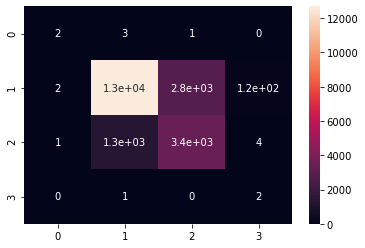

In [646]:
show_cm(cm_train, labels)

In [647]:
cm_train

array([[    2,     3,     1,     0],
       [    2, 12692,  2844,   118],
       [    1,  1312,  3403,     4],
       [    0,     1,     0,     2]], dtype=int64)

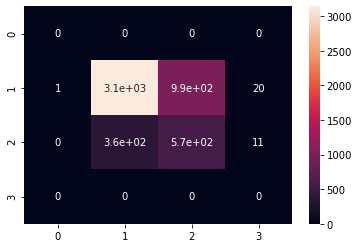

In [648]:
show_cm(cm_test, labels)

In [649]:
cm_test

array([[   0,    0,    0,    0],
       [   1, 3144,  992,   20],
       [   0,  359,  570,   11],
       [   0,    0,    0,    0]], dtype=int64)

## Feature Importance

In [650]:
# L'importance permet de connaitre l'importance d'une colonne
# par rapport aux autres colonnes.

clf.fit(X_tr, Y_tr)                       # On re-train nos valeurs
importance = clf.feature_importances_   
importance

array([5.57001874e-02, 4.08830936e-03, 4.84677370e-02, 6.00441632e-02,
       0.00000000e+00, 5.82057494e-02, 5.05349390e-02, 4.81056565e-02,
       5.82638291e-02, 1.89607077e-02, 3.97492769e-02, 1.42669911e-02,
       2.74540772e-02, 9.69903485e-04, 8.88179747e-06, 1.37196512e-02,
       1.72276154e-04, 9.25355786e-03, 1.76305998e-04, 6.64342664e-04,
       0.00000000e+00, 1.60298825e-03, 3.64563548e-03, 1.90448805e-05,
       4.46414535e-02, 0.00000000e+00, 5.04258957e-03, 4.16190792e-03,
       3.58692842e-03, 3.42764851e-03, 8.70730593e-03, 1.82309885e-02,
       3.16634508e-02, 3.66250350e-02, 3.70746646e-02, 5.06306734e-02,
       2.85563066e-02, 8.56427651e-03, 1.83579297e-02, 3.17048445e-02,
       3.67400346e-02, 3.90267699e-02, 4.99589284e-02, 2.92240522e-02])

In [667]:
# On renomme nos colonnes

name = X_tr.columns.tolist()
colNumberList = list(range(len(X_tr.columns)))
name = np.char.replace(name, 'lower_bound_ip_address', 'lower_bound_ip_addr')
name = np.char.replace(name, 'upper_bound_ip_address', 'upper_bound_ip_addr')

Features:

0  Unnamed: 0: (6.004416)
1  Source: (5.826383)
2  TMC: (5.820575)
3  City: (5.570019)
4  Country: (5.063067)
5  Airport_Code: (5.053494)
6  Temperature(F): (4.995893)
7  Humidity(%): (4.846774)
8  Pressure(in): (4.810566)
9  Visibility(mi): (4.464145)
10  Wind_Speed(mph): (3.974928)
11  Precipitation(in): (3.902677)
12  Weather_Condition: (3.707466)
13  Amenity: (3.674003)
14  Bump: (3.662503)
15  Crossing: (3.170484)
16  Give_Way: (3.166345)
17  Junction: (2.922405)
18  No_Exit: (2.855631)
19  Railway: (2.745408)
20  Roundabout: (1.896071)
21  Station: (1.835793)
22  Stop: (1.823099)
23  Traffic_Calming: (1.426699)
24  Traffic_Signal: (1.371965)
25  Turning_Loop: (0.925356)
26  Sunrise_Sunset: (0.870731)
27  Civil_Twilight: (0.856428)
28  Nautical_Twilight: (0.504259)
29  Astronomical_Twilight: (0.416191)
30  Start_Time_year: (0.408831)
31  Start_Time_month: (0.364564)
32  Start_Time_week: (0.358693)
33  Start_Time_day: (0.342765)
34  Start_Time_hour: (0.160299)
35  Start_

<Figure size 432x288 with 0 Axes>

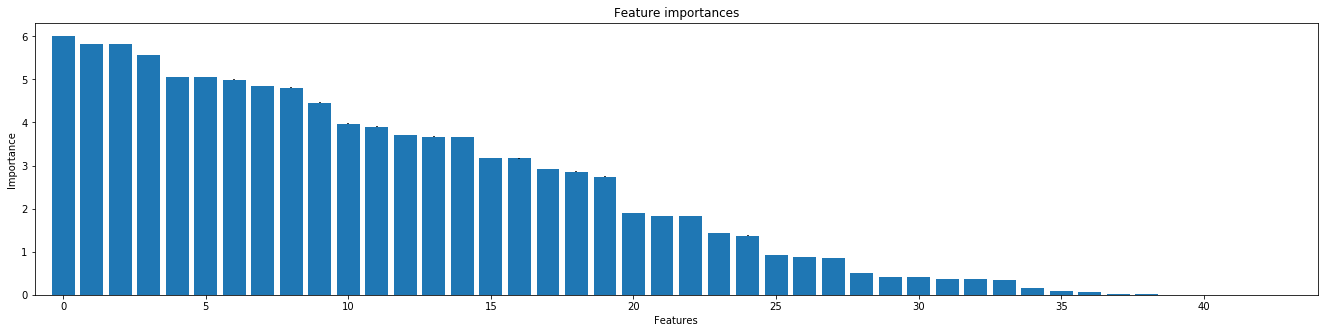

In [669]:
# On souhaite Afficher dans un graphique notre importance

std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importance)[::-1]

# Affichage de nos features avec leur pourcentage
print("Features:")
print()

for f in range(X.shape[1]):
    print("%d  %s: (%f)" % (f, X_tr.columns[f], importance[indices[f]]*100))

# Affichage de notre Features importance
plt.figure()
plt.subplots(figsize=(23,5))                                              #Taille de la figure
plt.title("Feature importances")
plt.xlabel('Features')
plt.ylabel('Importance')
plt.bar(colNumberList, importance[indices]*100, yerr=std[indices], align="center") # Valeur en X, Hauteur, Largeur, alignement
plt.xlim([-1, X.shape[1]])                                                # Limite de l'axe X
plt.show()

## Affichage du nombre d'accident en fonction

In [ ]:
# L'objectif est d'afficher le Nombre d'attaque en fonction des pays
# On affichera uniquement les 10 pays les plus attaqué

accident_wo_class0 = accident[accident['class'] == 1]              # On s'interessera qu'au fraude qui on eu lieu
city_by_class = pd.DataFrame()                         # On crée un nouveau dataframe
country_by_class['country'] = fd_ip['country']            # On ajoute à notre dataset la colonne country
country_by_class['class'] = fd_ip['class']                # On ajoute à notre dataset la colonne classe
total = country_by_class.groupby(by="country",as_index=False).sum().sort_values(by='class', ascending=False) # On groupe tout nos country en en fonction de la somme de nos class par ordre décroissant

total.head(10)                                            # On affiche le total


In [ ]:
df = total.head(10)

sns.barplot(df['class'], df['country']).set_title("Nombre de fraude en fonction des pays");

## Affichage des accidents en fonction des états

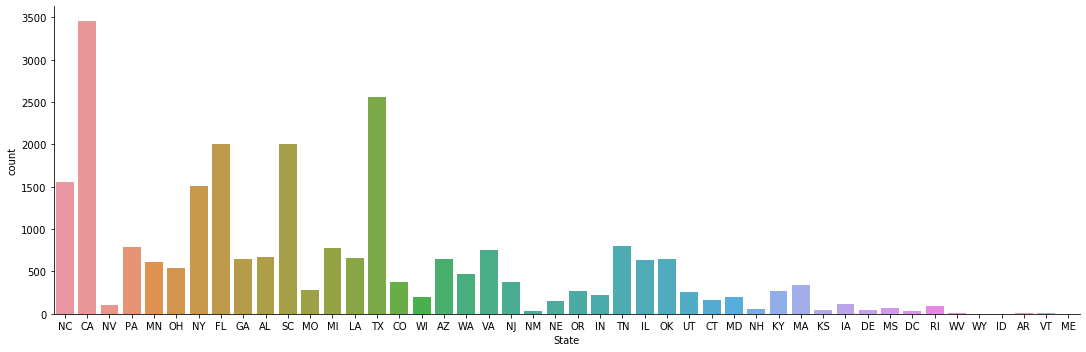

In [701]:
sns.catplot(x='State', kind='count',data=accident, height=5, aspect=3) 

Nous pouvons voir dans le diagramme ci-dessus que certains états on beaucoup plus d'accidents que d'autres. En l'occurence:
<ul>
    <li>La Californie (CA) avec 3458 accidents</li>
    <li>Le Texas (TX) avec 2557 accidents</li>
    <li>La Floride (FL) avec 2010 accidents</li>
    <li>La Caroline du Sud (SC) avec 2006 accidents</li>
    <li>La Caroline du Nord (NC) avec 1555 accidents</li>
    <li>New York (NY) avec 1507 accidents</li>
</ul>

ont beaucoup plus d'accidents que la pluparts des autres pays. Nous allons alors essayer de nous intérésser aux raisons de cela.

In [710]:
accident.query("(State == 'NC')").count

<bound method DataFrame.count of        Unnamed: 0    Source    TMC  Severity           Start_Time  \
3          820712  MapQuest  201.0         2  2019-10-15 09:28:51   
71        1208755  MapQuest  201.0         2  2019-04-02 08:10:53   
100        707546  MapQuest  201.0         2  2020-02-11 08:25:44   
113       1611927  MapQuest  201.0         3  2018-10-26 14:11:46   
149        862332  MapQuest  201.0         2  2019-11-04 07:34:55   
...           ...       ...    ...       ...                  ...   
99828     1197123  MapQuest  201.0         2  2019-05-30 11:50:29   
99948      641876  MapQuest  201.0         2  2020-01-05 18:22:13   
99952      949211  MapQuest  201.0         2  2019-09-27 10:40:45   
99953      626013  MapQuest  201.0         3  2020-04-20 10:35:56   
99967      898528  MapQuest  201.0         2  2019-11-20 07:48:55   

                  End_Time           City       County State Airport_Code  \
3      2019-10-15 10:28:40        Raleigh         Wake    NC 